In [1]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch

import plotnine
from plotnine import *

dpi = 300

In [2]:
from imp import load_source
nanospot=load_source('nanospot', '/home/jovyan/python/Nanospot/nanospot/nanospot.py')

In [3]:
result_path='/lustre/scratch117/cellgen/team283/tl7/project/nanostring-covid/data/SpaceJam/LungAtlas_model/results/20220316_SpaceJam_UKCIC36Donor/'
result_directory='LocationModelWTAMultiExperimentHierarchicalGeneLevel_5experiments_62clusters_80locations_7837genes_control_geneE-6_cellE6/'
sp_adata=sc.read_h5ad(f"{result_path}{result_directory}sp.h5ad")
sp_adata.obs['area mm2']=np.array(sp_adata.obs['area um2'] * 1e-6)


abundance_df=nanospot.plot_C2L_results()
abundance_df.create_scatter_df(sp_adata, background='Control')

/software/team283/tl7/conda_env/spacejam/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
result_path='/lustre/scratch117/cellgen/team283/tl7/project/nanostring-covid/data/SpaceJam/LungAtlas_model/results/20220411_SpaceJam_UKCIC33Donor/'

result_directory='LocationModelWTAMultiExperimentHierarchicalGeneLevel_23experiments_62clusters_94locations_10276genes_PRESPRES-likeACFF_cell1e6/'
sp_adata=sc.read_h5ad(f"{result_path}{result_directory}sp.h5ad")

result_directory='LocationModelWTAMultiExperimentHierarchicalGeneLevel_28experiments_62clusters_139locations_10276genes_MDADODAD-likeODADBRON_cell1e6/'

sp_adata=sp_adata.concatenate(sc.read_h5ad(f"{result_path}{result_directory}sp.h5ad"))
sp_adata.obs['area mm2']=np.array(sp_adata.obs['area'] * 1e-6, dtype='float32')

abundance_df.create_scatter_df(sp_adata, background='COVID-19')

### Figure 4A

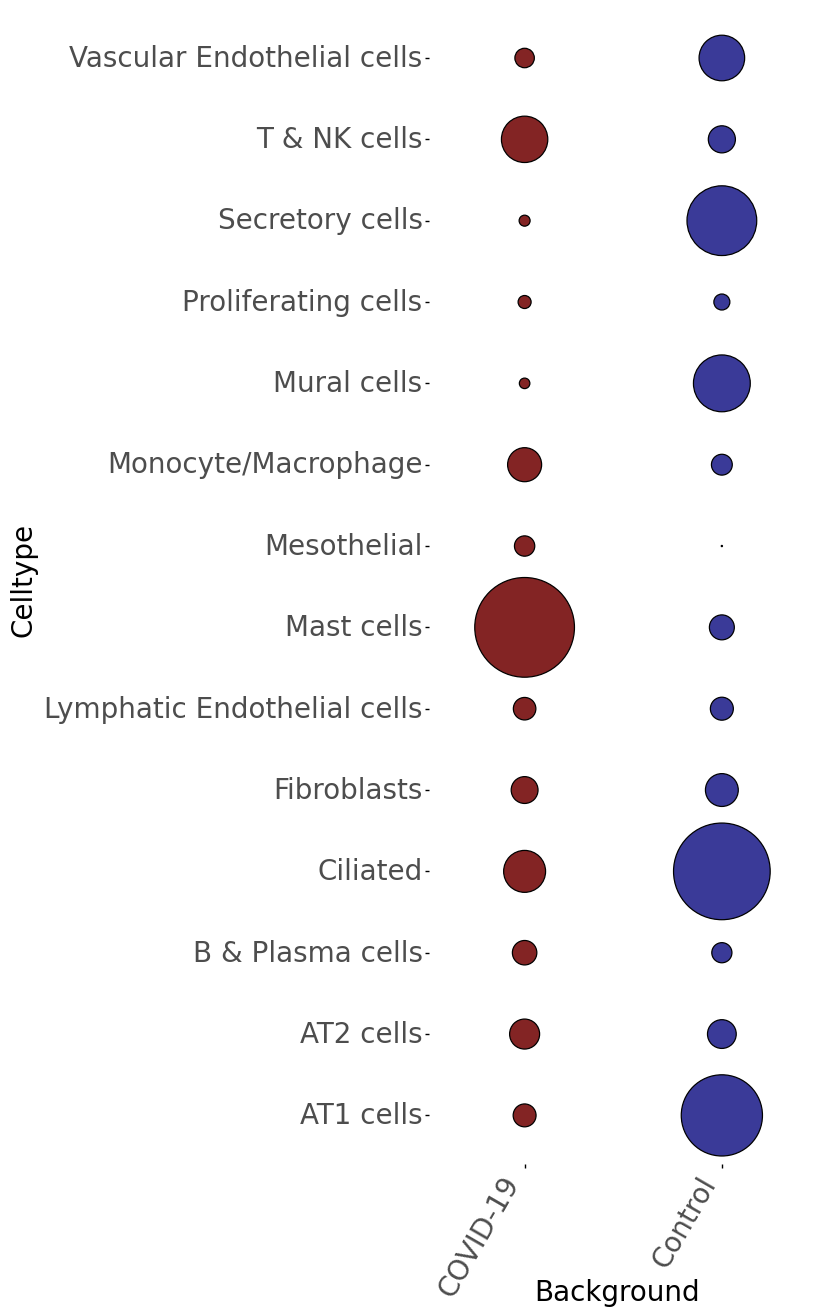

<ggplot: (8732798025465)>

In [5]:
plotnine.options.figure_size=(5,15)
plotnine.dpi = dpi


plot_abundance_disease = pd.read_csv("../data/fig4_celltype_abundance_percentage_diseases.csv", sep=",", index_col = 0)

p1 = (
        ggplot() +
        geom_point(data = plot_abundance_disease, mapping = aes(x = "Background", y = "Celltype", fill = "Background", size = "Abundance" )) +
        theme_bw() +
        theme(axis_text_x = element_text(angle = 60, vjust = 1, hjust=1, size=20), 
              axis_text_y = element_text(size=20),
              title = element_text(size=36), 
              axis_title_x = element_text(size=20), 
              axis_title_y = element_text(size=20), 
              panel_grid_major_x = element_blank(),
              panel_grid_major_y = element_blank(),
              strip_background_x= element_blank(),
              strip_text_x = element_blank(),
              panel_border = element_blank(),
              legend_position = "none" ) + 
        scale_size_continuous(range=[0,40]) + 
        scale_fill_manual(breaks = ["COVID-19", "Control"], values=["#832424", "#3A3A98"]) +
        facet_grid(".~Background", scales = "free")
)

p1

### Figure 4B

In [6]:
from scipy.stats import ttest_ind
from statsmodels.stats import multitest
from re import sub


cell_abbreviations=pd.read_csv("/home/jovyan/projects/nanostring-covid/data/cell_altname_v1.csv", index_col=0, sep=',')
cell_abbreviations.index = cell_abbreviations.cell_states

cell_abbreviations=cell_abbreviations['alt_name'].to_dict()

abundance_df.abudance_df["Celltype"] = [cell_abbreviations.get(cell) for cell in abundance_df.abudance_df.Celltype]


tmp_df=abundance_df.abudance_df
p_value_result=[]

for cell in tmp_df['Celltype'].unique():
    tmp_df_celltype=tmp_df[tmp_df.Celltype == cell]
    tstat, p = ttest_ind(
        np.array(tmp_df_celltype[tmp_df_celltype['Background']=='Control'].Abundance), 
        np.array(tmp_df_celltype[tmp_df_celltype['Background']=='COVID-19'].Abundance)
    )
    p_value_result.append(round(p, 5))


p_value_result = multitest.multipletests(p_value_result, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)


p_val_df=pd.DataFrame({
    'Celltype': np.array(tmp_df['Celltype'].unique()),
    'p_value': [sub("^(.{5}).*",  "\\1", pval ) for pval in p_value_result[1].astype('str') ]
})
p_val_df


cell_type_pval=[]

for cell in tmp_df['Celltype']:
    cell_type_pval.append(f"{cell}\np={p_val_df[p_val_df['Celltype'] == cell].p_value.astype('str')}")

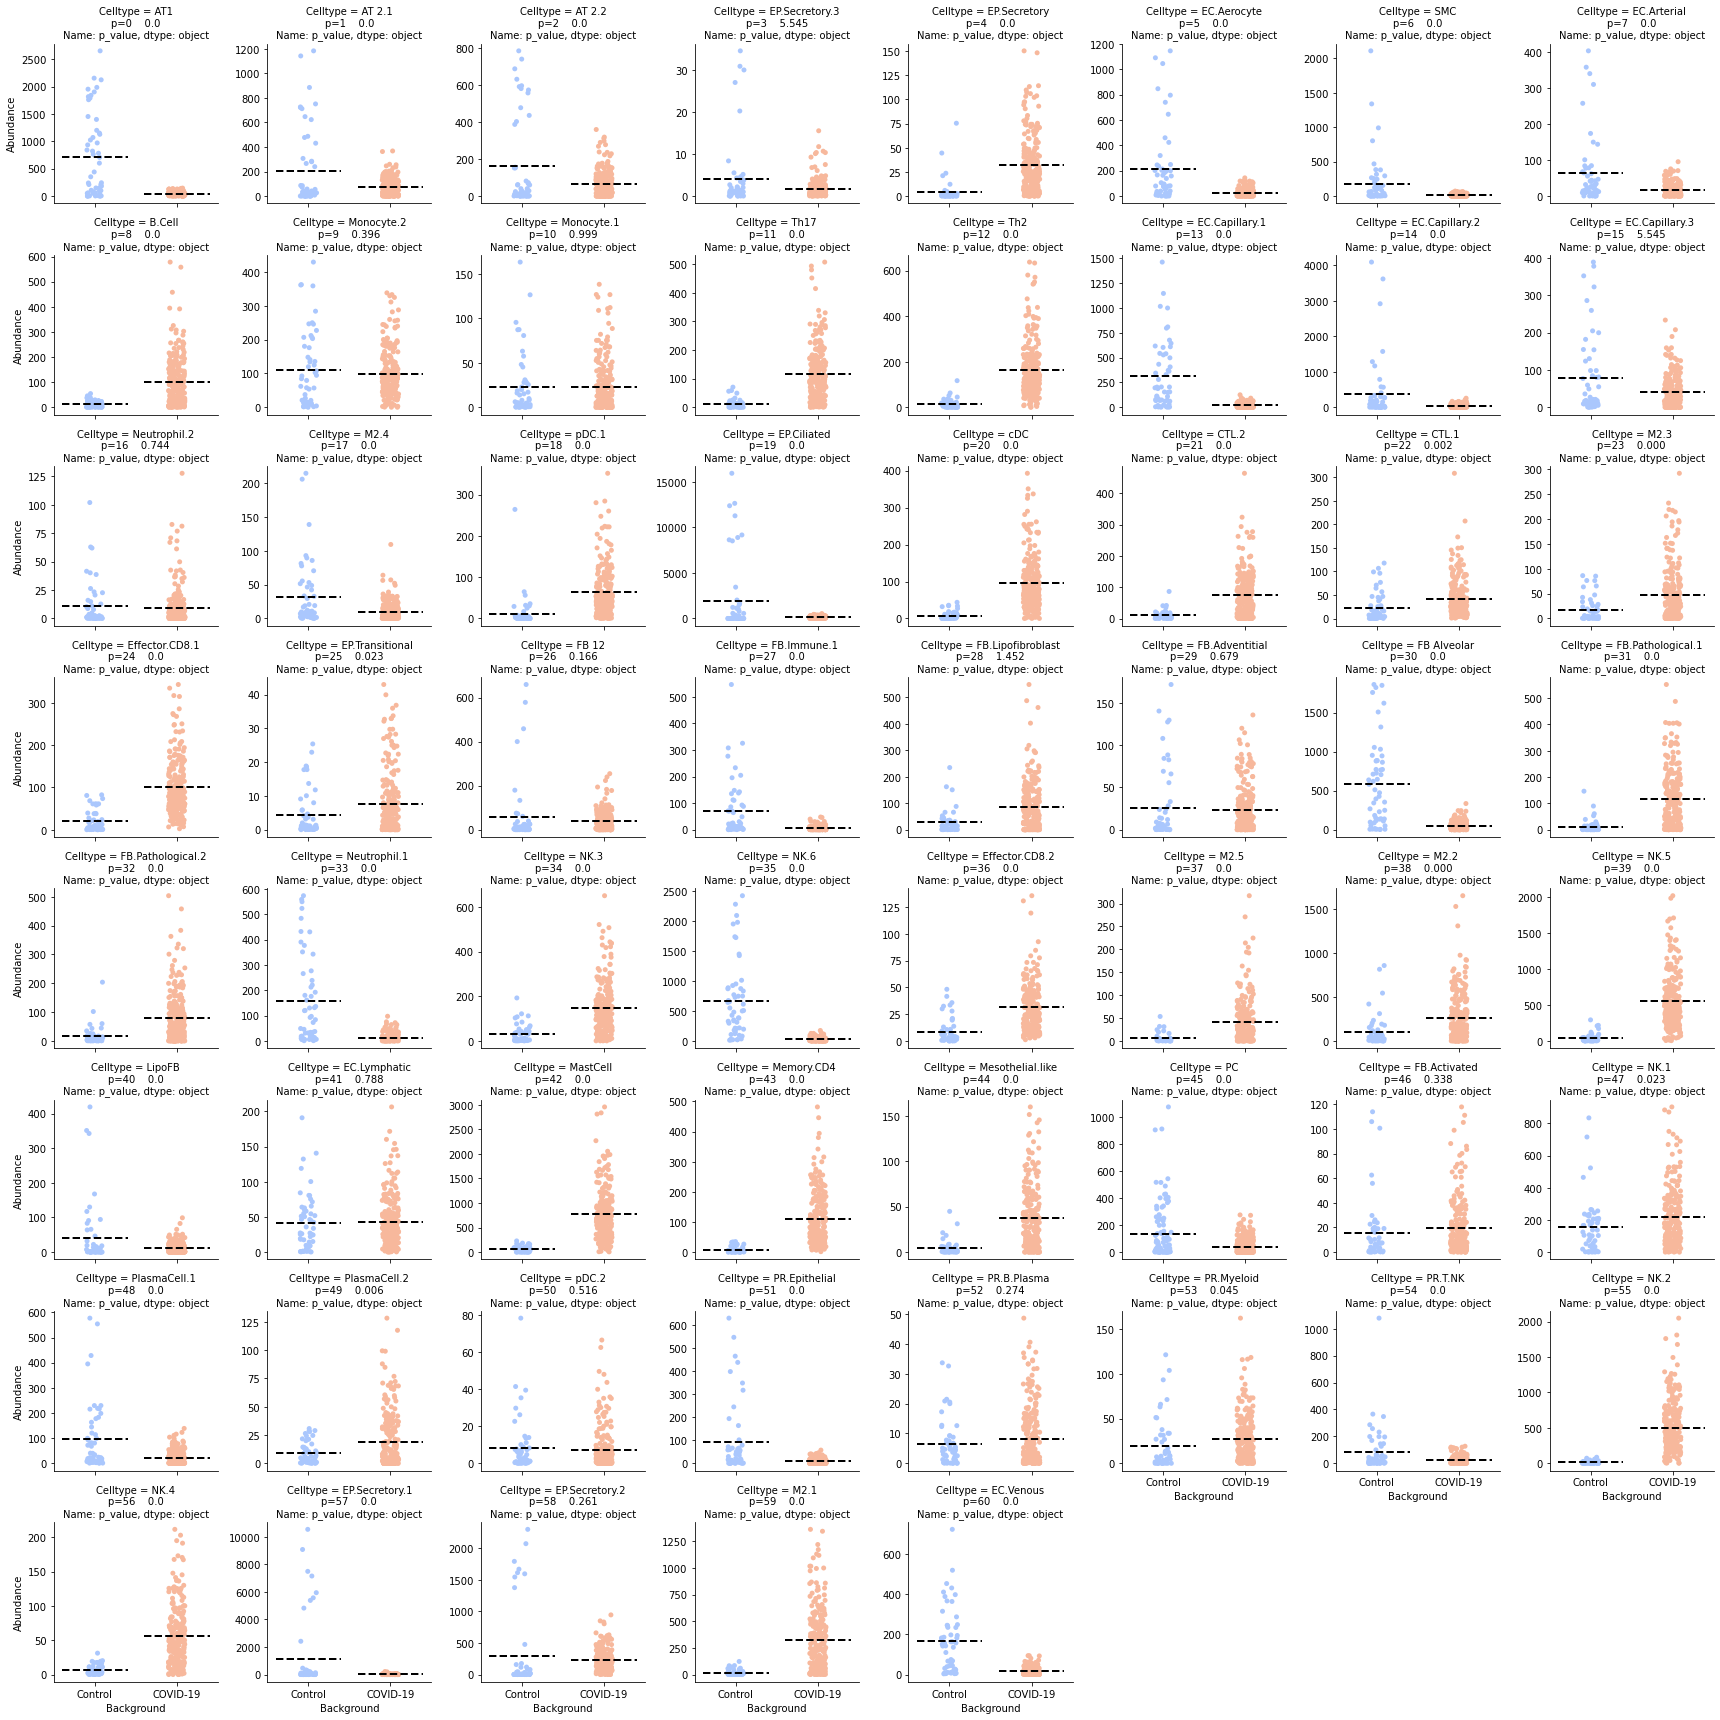

In [7]:
abundance_df_stat=abundance_df
abundance_df_stat.abudance_df['Celltype'] = np.array(cell_type_pval).flatten()
abundance_df_stat.plot_scatter(col_wrap=8)